# RAGU radar pick length calculator
Notebook designed to calculate the length of radar data interpreted and uninterpreted.

RAGU pick files may contain arrays for a particular track which have picks along subsections of that track.

Therefore, calculating the total length of all line segments will over-estimate the length of picked data.

Here, we split up tracks based on the trace increment and then calculate the length of measurements in line-km.

BST 20221206


### psuedocode ###
1. read in dataset containing RAGU radar picks
    a. remove nulls where no picks were made
2. break up each track into subsections based on the trace increment
    a. if the along-track trace increment is greater than 1, split track measurements into n chunks
3. create geodataframe and make linestring from points
4. calculate measurement distance

In [1]:
### impots ###
import sys, os, itertools
import numpy as np
import pandas as pd
import pyproj
import fiona
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import split
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 10
pd.set_option('display.max_rows', 500)

In [2]:
### function declarations ###

def project_array(x=None, y=None, from_epsg=4326, to_epsg=3338, always_xy=True):
    """
    use pyproj to project our x,y data
    
    inputs:
    x = input x value array
    y = input y value array
    from_epsg = source epsg code for our x,y points
    to_epsg = destination epsg code for our points
    always_xy = boolean, whether or not input points are always in x,y order
    
    returns:
    fx = x points projected from_epsg to_epsg
    fy = y points projected from_epsg to_epsg
    """
    tform = pyproj.Transformer.from_crs(crs_from=from_epsg, crs_to=to_epsg, always_xy=always_xy)
    fx, fy = tform.transform(x, y)
    return fx,fy

In [3]:
### params ###
# dpath = "C:/Users/btober/OneDrive/Documents/tmp/"
dpath = "C:/Users/btober/OneDrive/Documents/MARS/orig/xtra/OIB-AK/radar/"

# df = pd.read_csv(dpath + 'ruth_picks.csv')  
df = pd.read_csv(dpath + 'OIB-AK_pk_bst.csv')
# df = pd.read_csv(dpath + 'IRUAFHF1B/pick/IRUAFHF1B_pick_bst.csv')
# df = df.append(pd.read_csv(dpath + 'IRARES1B/pick/IRARES1B_pick_bst.csv'), ignore_index=True)
df.head()

,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_amp,bed_elev,srf_bed_thick
0,IRUAFHF1B_20130322-205751,0,-142.755324,60.889714,1660.484070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IRUAFHF1B_20130322-205751,1,-142.755481,60.889310,1658.535081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IRUAFHF1B_20130322-205751,2,-142.755557,60.889108,1657.981002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IRUAFHF1B_20130322-205751,3,-142.755634,60.888906,1657.426938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IRUAFHF1B_20130322-205751,4,-142.755711,60.888704,1656.625443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# filter out any nulls to get line-km of picked data
df = df[df.bed_sample.notnull()]

Need to split up points for a given track based on the trace interval.

If the difference betweeen consecutive traces in the dataframe is greater than 1, we want to create a new linesegment

In [5]:
# create new df for which we'll split chunks of picked tracks
df_chunks = pd.DataFrame()

# get unique track names
tracks = df.track.unique()

# loop through tracks and split points by trace chunks - where diff of trace is greater than 1
for t in tracks:
    # print(t)
    subdf = df[df.track == t]
    # ensure we're sorted by increasing trace value
    subdf = subdf.sort_values(by=['trace'],ignore_index=True)
    # get along track difference in trace index
    diff = np.diff(subdf.trace)
    # find where difference in trace value is greater than 1
    idx = np.where(diff > 1)
    # determine how many chunks in track based on trace diff. nchunks will be idx[0].shape[0]+1 (one split means two subsections, etc.)
    nchunks = idx[0].shape[0] + 1

    # now iterate and split subsections if there's more than 1 chunk
    if nchunks > 1:
        # print(t)
        # plt.figure()
        # plt.plot(diff,'.')
        for i in range(nchunks):
            # print(traces.iloc[idx[0][i]-1], traces.iloc[idx[0][i]], traces.iloc[idx[0][i]+1])
            if i == 0:
                start = 0
                stop = idx[0][i]

            elif i >= 1:
                start = idx[0][i - 1] + 1
                if i == nchunks-1:
                    stop = subdf.index[-1]
                else:
                    stop = idx[0][i]

            # add subset to gpd as with new track id
            # print(start,stop)
            # print(subdf.trace.iloc[start],subdf.trace.iloc[stop])
            sub = subdf.iloc[start:stop]
            sub.track = t + '_' + str(i)
            df_chunks = df_chunks.append(sub)
            
    else:
        df_chunks = df_chunks.append(subdf)    

c:\Users\btober\anaconda3\envs\py3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
df_chunks.head()

,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_amp,bed_elev,srf_bed_thick
0,IRUAFHF1B_20130322-205751,613,-142.744553,60.753280,1306.625003,858.0,0.000004,663.570180,0.000290,1182.0,0.000006,0.000041,526.749910,136.820271
1,IRUAFHF1B_20130322-205751,614,-142.744384,60.753082,1306.442512,855.0,0.000004,665.636133,0.000257,1185.0,0.000006,-0.000022,526.282153,139.353979
2,IRUAFHF1B_20130322-205751,615,-142.744215,60.752885,1306.260013,853.0,0.000004,666.952596,0.000210,1187.0,0.000006,-0.000027,525.909478,141.043118
3,IRUAFHF1B_20130322-205751,616,-142.744045,60.752688,1306.145499,850.0,0.000004,669.086526,0.000185,1189.0,0.000006,-0.000024,525.931983,143.154542
4,IRUAFHF1B_20130322-205751,617,-142.743875,60.752492,1306.031000,848.0,0.000004,670.470989,0.000118,1191.0,0.000006,0.000016,525.627308,144.843681


In [7]:
# zip the coordinates into a point object and convert to a GeoData Frame
points = [Point(xy) for xy in zip(df_chunks.lon, df_chunks.lat)]
gdf = gpd.GeoDataFrame(df_chunks, geometry=points, crs = 'EPSG:4326')
gdf.to_crs('EPSG:3338',inplace=True)
gdf.head()

,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_amp,bed_elev,srf_bed_thick,geometry
0,IRUAFHF1B_20130322-205751,613,-142.744553,60.753280,1306.625003,858.0,0.000004,663.570180,0.000290,1182.0,0.000006,0.000041,526.749910,136.820271,POINT (608480.329 1248226.971)
1,IRUAFHF1B_20130322-205751,614,-142.744384,60.753082,1306.442512,855.0,0.000004,665.636133,0.000257,1185.0,0.000006,-0.000022,526.282153,139.353979,POINT (608493.116 1248206.756)
2,IRUAFHF1B_20130322-205751,615,-142.744215,60.752885,1306.260013,853.0,0.000004,666.952596,0.000210,1187.0,0.000006,-0.000027,525.909478,141.043118,POINT (608505.904 1248186.542)
3,IRUAFHF1B_20130322-205751,616,-142.744045,60.752688,1306.145499,850.0,0.000004,669.086526,0.000185,1189.0,0.000006,-0.000024,525.931983,143.154542,POINT (608518.695 1248166.415)
4,IRUAFHF1B_20130322-205751,617,-142.743875,60.752492,1306.031000,848.0,0.000004,670.470989,0.000118,1191.0,0.000006,0.000016,525.627308,144.843681,POINT (608531.487 1248146.288)


In [8]:
# treat each `track` group of points as a line
lines_picked = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
lines_picked = gpd.GeoDataFrame(lines_picked, geometry="geometry", crs='EPSG:3338')
lines_picked.reset_index(inplace=True)

lines_picked.head()

,track,geometry
0,IRARES1B_20160528-224052,"LINESTRING (750029.726 1165752.975, 750017.458..."
1,IRARES1B_20160528-231221_0,"LINESTRING (730384.649 1166106.304, 730399.849..."
2,IRARES1B_20160528-231221_1,"LINESTRING (734308.591 1165486.845, 734319.909..."
3,IRARES1B_20160528-231221_2,"LINESTRING (743889.855 1164009.905, 743900.740..."
4,IRARES1B_20160528-232447_0,"LINESTRING (742715.295 1162036.781, 742702.285..."


In [9]:
# load in all radar tracks
lines = gpd.GeoDataFrame()
fname = 'C:/Users/btober/OneDrive/Documents/MARS/orig/supl/gis/OIB-AK/vector/radar/OIB-AK_tracks.gpkg'
for layername in fiona.listlayers(fname):
    print(layername)
    lines = lines.append(gpd.read_file(fname, layer=layername, crs='EPSG:4326'))
lines.to_crs('EPSG:3338', inplace=True)
lines.rename(columns={'fname':'track'},inplace=True)
lines.head()

2013
2014
2015
2016
2017
2018
2019
2020
2021


,radar,stop_time,start_time,track,day,month,year,numTrace,centerFrequency,geometry
0,None,21:14:12,20:50:05,IRUAFHF1B_20130328-205005.h5,28,3,2013,1441,2000000.0,"LINESTRING Z (809105.758 1221504.907 1504.346,..."
1,None,22:10:22,21:33:26,IRUAFHF1B_20130523-213326.h5,23,5,2013,2184,2000000.0,LINESTRING Z (1279437.670 1015019.027 1860.944...
2,None,21:20:12,21:13:54,IRUAFHF1B_20130322-211354.h5,22,3,2013,379,2000000.0,"LINESTRING Z (621460.999 1228935.872 2013.948,..."
3,None,17:34:28,16:59:27,IRUAFHF1B_20130328-165927.h5,28,3,2013,2073,2000000.0,"LINESTRING Z (642189.379 1214595.622 1905.778,..."
4,None,21:50:23,21:20:17,IRUAFHF1B_20130322-212017.h5,22,3,2013,1735,2000000.0,"LINESTRING Z (621098.516 1223614.623 1688.796,..."


plot distance picked/distance acquired v year

In [10]:
yrs = np.arange(2013,2022)
dist_flown = [(np.sum(lines[lines.track.str.contains('IRUAFHF1B_'+ str(i))].length)*1e-3 + np.sum(lines[lines.track.str.contains('IRARES1B_'+ str(i))].length)*1e-3) for i in yrs]
dist_picked = [(np.sum(lines_picked[lines_picked.track.str.contains('IRUAFHF1B_'+ str(i))].length)*1e-3 + np.sum(lines_picked[lines_picked.track.str.contains('IRARES1B_'+ str(i))].length)*1e-3) for i in yrs]
pct = [100*(dist_picked[i]/dist_flown[i]) for i in range(len(yrs))]
mean_agl = [np.nanmean((
                        np.nanmean(
                                (gdf[gdf.track.str.contains('IRUAFHF1B_'+ str(i))].elev) - 
                                (gdf[gdf.track.str.contains('IRUAFHF1B_'+ str(i))].srf_elev)),
                        np.nanmean(
                                (gdf[gdf.track.str.contains('IRARES1B_'+ str(i))].elev) - 
                                (gdf[gdf.track.str.contains('IRARES1B_'+ str(i))].srf_elev))
                                )) for i in yrs]

C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:9: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:9: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:9: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(
C:\Users\btober\AppData\Local\Temp\ipykernel_16320\3466620215.py:6: RuntimeWarning: Mean of empty slice
  np.nanmean(


In [11]:
for n, i in enumerate(yrs):
    print(i, '\t' ,round(dist_flown[n]), '\t' ,round(dist_picked[n]), '\t' ,round(mean_agl[n]), '\t', round(pct[n]))

2013 	 2748 	 167 	 362 	 6
2014 	 3094 	 226 	 328 	 7
2015 	 3046 	 664 	 329 	 22
2016 	 4442 	 455 	 444 	 10
2017 	 1991 	 162 	 444 	 8
2018 	 7533 	 857 	 339 	 11
2019 	 4047 	 616 	 328 	 15
2020 	 3488 	 392 	 226 	 11
2021 	 5427 	 1974 	 264 	 36


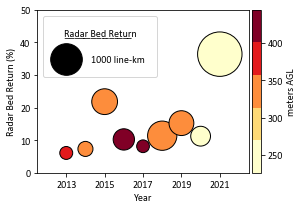

In [12]:
fig, ax = plt.subplots(1, figsize=(4,3))
cmap = plt.get_cmap('YlOrRd', 5)

ax.set_ylim([0,50])
ax.set_xlim([2011.5,2022.5])
ax.set_xticks(yrs[::2])
ax.set_xlabel('Year')
ax.set_ylabel('Radar Bed Return (%)')

scatter = ax.scatter(yrs, pct, s=dist_picked, c=mean_agl, alpha=0.8,
            cmap=cmap, edgecolors='k', label=None)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cb=fig.colorbar(scatter, cax=cax, orientation='vertical', label='meters AGL')

kw = dict(prop="sizes", num=2, fmt="{x:.0f} line-km")
legend = ax.legend(*scatter.legend_elements(**kw),
                    loc="upper left", handletextpad=1.5, frameon=True, labelspacing=1.8, borderaxespad=0.6, borderpad=1.25,title="\u0332".join('Radar Bed Return'))

fig.savefig('C:/Users/btober/OneDrive/Documents/pres/OIB-AK/pub/oib_success.jpg', dpi=400)

In [13]:
print(f'acquired radar data length {round(np.sum(lines.length)*1e-3,3)} line-km')
print(f'picked radar data length {round(np.sum(lines_picked.length)*1e-3,3)} line-km')
print(f'{round(100*(np.sum(lines_picked.length) / np.sum(lines.length)))} % total bed return')

acquired radar data length 35816.247 line-km
picked radar data length 5513.381 line-km
15 % total bed return


Quantify bed picks per glacier using RGI outlines

In [22]:
# load rgi v 6
shp = gpd.read_file('C:/Users/btober/OneDrive/Documents/MARS/orig/supl/gis/OIB-AK/vector/rgi_v6_ak.shp', crs='EPSG:4326')
# remove aleutian's and n. slope since no data there for sure
shp = shp[shp['O2Region']!='1']
shp = shp[shp['O2Region']!='3']
shp.to_crs('EPSG:3338', inplace=True)
shp.head()

,fid,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,1.0,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.823,63.689,1,2,0.360,...,346,839,0,0,0,0,9,9,None,"POLYGON ((353922.294 1544106.403, 353969.125 1..."
1,2.0,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.668,63.404,1,2,0.558,...,162,1197,0,0,0,0,9,9,None,"POLYGON ((364992.649 1513500.001, 364998.450 1..."
2,3.0,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.080,63.376,1,2,1.685,...,175,2106,0,0,0,0,9,9,None,"POLYGON ((394593.022 1514199.292, 394592.816 1..."
3,4.0,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.120,63.381,1,2,3.681,...,195,4175,0,0,0,0,9,9,None,"POLYGON ((390852.892 1513270.533, 390859.011 1..."
4,5.0,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.057,63.551,1,2,2.573,...,181,2981,0,0,0,0,9,9,None,"POLYGON ((344516.095 1527311.059, 344445.809 1..."


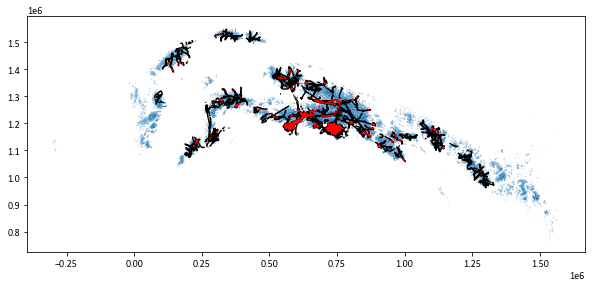

In [23]:
fig, ax = plt.subplots(1,figsize=(10,10))
shp.plot(ax=ax)
ln0 = lines.plot(ax=ax,color='k')
ln1 = lines_picked.plot(ax=ax, color='r')
ax.set_aspect('equal')

Loop through RGIId and count block reduced bed picks

5513.38073558904
1595.2328090018102


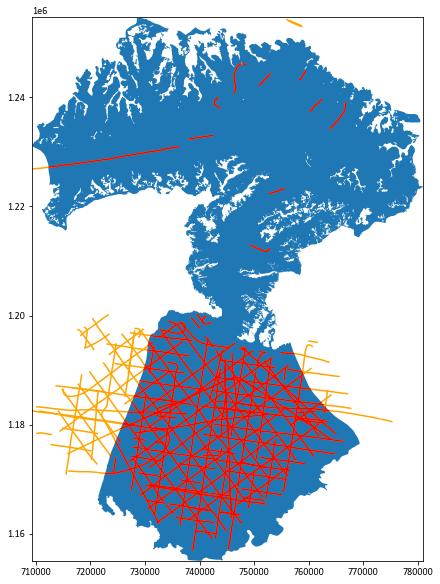

In [24]:
# first check just one glacier outline - seward
test_poly = shp[shp.RGIId=='RGI60-01.13696']
test_lines = gpd.clip(test_poly, lines_picked)
print(lines_picked.length.sum()*1e-3)
print(test_lines.length.sum()*1e-3)

fig, ax = plt.subplots(1,figsize=(10,10))
test_poly.plot(ax=ax)
ln1 = lines_picked.plot(ax=ax, color='orange')
test_lines.plot(ax=ax,color=['red'])
ax.set_xlim([test_poly.bounds.minx.to_numpy(), test_poly.bounds.maxx.to_numpy()])
ax.set_ylim([test_poly.bounds.miny.to_numpy(), test_poly.bounds.maxy.to_numpy()])
ax.set_aspect('equal')

It worked! alright, now loop through all outlines and add up line-distance flown per outline and line-distance picked

In [17]:
# for _i in shp['RGIId']:
#     tmp_lines = gpd.clip(sub, lines)


#     sub = shp[shp['RGIId']==_i]
#     tmp_lines = gpd.clip(sub, lines)
#     sub['flight_dist_km'] = tmp_lines.length.sum()*1e-3
#     tmp_lines = gpd.clip(sub, lines_picked)
#     sub['picked_dist_km'] = tmp_lines.length.sum()*1e-3

In [25]:
print(type(shp))
print(type(test_poly))
print(type(shp.iloc[[0]]))

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [27]:
lines_clipped = gpd.clip(shp, lines)

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,10))
shp.plot(ax=ax)
ln0 = lines.plot(ax=ax,color='k')
ln1 = lines_picked.plot(ax=ax, color='r')
ax.set_aspect('equal')

In [26]:
for index in range(len(shp)):
    # print(shp.loc[[index]])
    # print(type(row))
    # tmp_lines = gpd.clip(shp.loc[[index]], lines)
    print(gpd.clip(shp.loc[[index]], lines).length*1e-3)

KeyboardInterrupt: 